In [1]:
from __future__ import print_function

import numpy as np
import warnings
from glob import glob

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input,Flatten,Dense,Conv2D,MaxPooling2D,GlobalMaxPooling2D,GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

In [2]:
source_dir = "G:/BracU/Thesis/Federated Dataset/PlantVillage/Train"
test_dir = "G:/BracU/Thesis/Federated Dataset/PlantVillage/Test"
client_dirs = glob(source_dir+ "/*")

In [3]:
input_shape = (128, 128)
batch_size = 64

generators_train_client = []
generators_val_client = []

for i in range(0, len(client_dirs)):
    datagen_train = ImageDataGenerator(rescale=1./255, validation_split=0.1)
    generator_train = datagen_train.flow_from_directory(directory=client_dirs[i],
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    class_mode='sparse',
                                                    subset="training",
                                                    shuffle=True)
    generator_val = datagen_train.flow_from_directory(directory=client_dirs[i],
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    class_mode='sparse',
                                                    shuffle=True)
    generators_train_client.append(generator_train)
    generators_val_client.append(generator_val)
num_classes = generators_train_client[0].num_classes

Found 4946 images belonging to 15 classes.
Found 544 images belonging to 15 classes.
Found 4948 images belonging to 15 classes.
Found 544 images belonging to 15 classes.
Found 4935 images belonging to 15 classes.
Found 541 images belonging to 15 classes.


In [4]:
datagen_test = ImageDataGenerator(rescale=1./255)
generators_test = datagen_train.flow_from_directory(directory=test_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    class_mode='sparse',
                                                    shuffle=False)

Found 4180 images belonging to 15 classes.


In [5]:
class Involution(keras.layers.Layer):
    def __init__(
        self, channel, group_number, kernel_size, stride, reduction_ratio, name
    ):
        super().__init__(name=name)

        # Initialize the parameters.
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Get the shape of the input.
        (_, height, width, num_channels) = input_shape

        # Scale the height and width with respect to the strides.
        self.height_out = height // self.stride
        self.width_out = width // self.stride

        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        # Define the kernel generation layer.
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.ReLU(),
                keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Define reshape layers
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                self.height_out,
                self.width_out,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                self.height_out,
                self.width_out,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(self.height_out, self.width_out, num_channels)
        )

        super().build(input_shape)

    def call(self, x):
        # Generate the kernel with respect to the input tensor.
        # B, H, W, K*K*G
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # reshape the kernel
        # B, H_out, W_out, K*K, 1, G
        kernel = self.kernel_reshape(kernel)

        # Extract input patches.
        # B, H_out, W_out, K*K*C
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )

        # Reshape the input patches to align with later operations.
        # B, H_out, W_out, K*K, C//G, G
        input_patches = self.input_patches_reshape(input_patches)

        # Compute the multiply-add operation of kernels and patches.
        # B, H_out, W_out, K*K, C//G, G
        output = tf.multiply(kernel, input_patches)
        # B, H_out, W_out, C//G, G
        output = tf.reduce_sum(output, axis=3)

        # Reshape the output kernel.
        # B, H_out, W_out, C
        output = self.output_reshape(output)

        # Return the output tensor and the kernel.
        return output, kernel


In [6]:
def hybrid_model_v1(input_tensor=None, classes=38):
    img_rows, img_cols = 128, 128  # Adjust as per your dataset
    img_channels = 3
    img_dim = (img_rows, img_cols, img_channels)
    img_input = Input(shape=img_dim)
    
    # Block 1: Involution followed by Convolution
    x, _ = Involution(channel=img_channels, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_1")(img_input)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    x = BatchNormalization()(x)

    # Block 2: Convolution followed by Involution
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv')(x)
    x, _ = Involution(channel=64, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_2")(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    x = BatchNormalization()(x)

    # Block 3: Increase filters and alternate
    x, _ = Involution(channel=64, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_3")(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4: Conv block with Dropout
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    x = Dropout(0.3)(x)

    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(128, activation='relu', name='fc1')(x)
    x = Dropout(0.3)(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    model = Model(inputs=img_input, outputs=x, name='hybrid_model_v1')
    return model


In [7]:
def scale_model_weights(weight, scalar):
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad

In [8]:
opt = Adam(lr=.001)  #0.0005
loss = 'sparse_categorical_crossentropy'
metrics = ['categorical_accuracy']

smlp_global = hybrid_model_v1
# Create and compile the global model
global_model = smlp_global(classes=num_classes)  # Instantiate the model first
global_model.compile(optimizer=Adam(), loss=loss, metrics=metrics)

# Create and compile the local model
local_model = smlp_global(classes=num_classes)  # Instantiate the model first
local_model.compile(optimizer=opt, loss=loss, metrics=metrics)

global_model.summary()


c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "hybrid_model_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 inv_1 (Involution)          ((None, 128, 128, 3),     26        
                              (None, 128, 128, 9, 1,             
                             1))                                 
                                                                 
 block1_conv (Conv2D)        (None, 128, 128, 32)      896       
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                   

Round:  1
Client:  1
Epoch 1/5
77/77 [==============================] - 20s 187ms/step - loss: 3.4445 - categorical_accuracy: 0.0313 - val_loss: 2.6793 - val_categorical_accuracy: 0.0000e+00
Epoch 2/5
77/77 [==============================] - 13s 173ms/step - loss: 1.9902 - categorical_accuracy: 0.0647 - val_loss: 2.7639 - val_categorical_accuracy: 0.0000e+00
Epoch 3/5
77/77 [==============================] - 13s 174ms/step - loss: 1.6864 - categorical_accuracy: 0.0461 - val_loss: 3.7874 - val_categorical_accuracy: 0.0000e+00
Epoch 4/5
77/77 [==============================] - 13s 174ms/step - loss: 1.3970 - categorical_accuracy: 0.0453 - val_loss: 5.2339 - val_categorical_accuracy: 0.0000e+00
Client:  2
Epoch 1/5
77/77 [==============================] - 14s 182ms/step - loss: 3.3857 - categorical_accuracy: 0.0160 - val_loss: 2.7010 - val_categorical_accuracy: 0.0000e+00
Epoch 2/5
77/77 [==============================] - 13s 174ms/step - loss: 1.8542 - categorical_accuracy: 0.0403 - val_

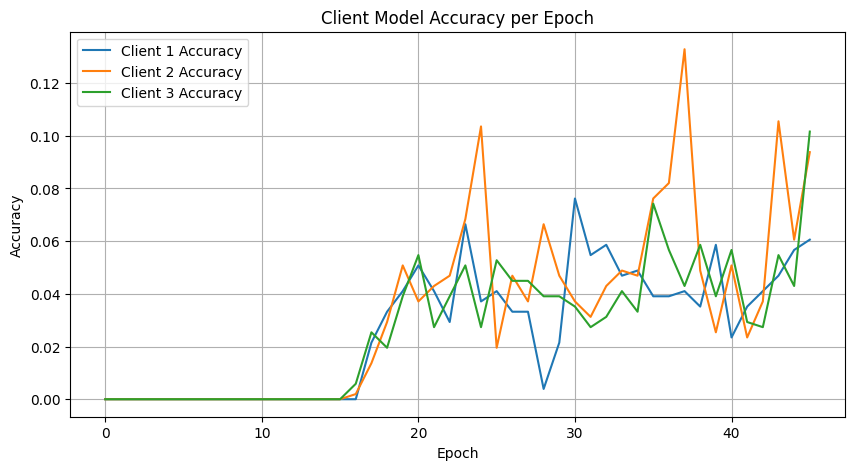

In [9]:
comms_round = 10
client_accuracies = [[] for _ in range(len(generators_train_client))]  # List to store accuracies for each client

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

for comm_round in range(comms_round):
    global_weights = global_model.get_weights()
    scaled_local_weight_list = []
    print("Round: ", comm_round+1)
    
    for client in range(len(generators_train_client)):
        print("Client: ", client + 1)
        local_model.set_weights(global_weights)
        steps_per_epoch = generators_train_client[client].n // batch_size
        steps_val = generators_val_client[client].n // batch_size
        
        # Fit model with early stopping
        history = local_model.fit(generators_train_client[client],
                                  epochs=5,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generators_val_client[client],
                                  validation_steps=steps_val,
                                  callbacks=[early_stopping])  # Add early stopping here

        # Append accuracy after each epoch to the respective client's accuracy list
        client_accuracies[client].extend(history.history['val_categorical_accuracy'])
        
        # Scale local weights and append to list
        scaled_local_weights = scale_model_weights(local_model.get_weights(), 1 / len(client_dirs))
        scaled_local_weight_list.append(scaled_local_weights)
    
    # Average the scaled weights and update the global model
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    global_model.set_weights(average_weights)
    
    # Evaluate global model
    scores = global_model.evaluate(generators_test)
    print("Communication round " + str(comm_round+1) + " global model accuracy is " + str(scores[1] * 100))
# Plot accuracy graph for each client
plt.figure(figsize=(10, 5))
for client in range(len(client_accuracies)):
    plt.plot(client_accuracies[client], label=f'Client {client + 1} Accuracy')
plt.title('Client Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

66/66 [==============================] - 3s 49ms/step


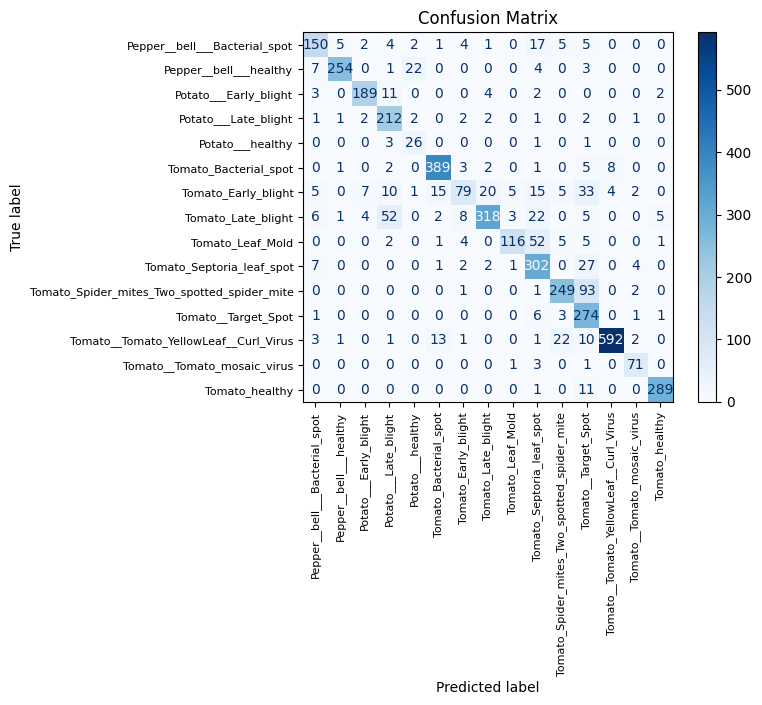

Final Accuracy: 83.97129186602871
Final F1-score: 83.95436446157758
Final Precision: 86.14488120930923
Final Recall: 83.97129186602871


In [10]:
scores = global_model.evaluate(generators_test)


# Calculate predictions
predictions = global_model.predict(generators_test)
y_true = generators_test.classes
y_pred = np.argmax(predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(generators_test.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize= 8)
plt.show()

# Calculate precision, recall, and F1-score
final_accuracy = accuracy_score(y_true, y_pred)
final_precision = precision_score(y_true, y_pred, average='weighted')
final_recall = recall_score(y_true, y_pred, average='weighted')
final_f1 = f1_score(y_true, y_pred, average='weighted')

# Print final results
print("Final Accuracy:", final_accuracy * 100)
print("Final F1-score:", final_f1 * 100)
print("Final Precision:", final_precision * 100)
print("Final Recall:", final_recall * 100)